## <b>■ 텐서 플로우를 활용한 신경망 구성 복습</b>
    1. 텐서플로우 1.x 버전 기본문법
            그래프 생성 영역
            --------------
            그래프 실행 영역
            
    2. 텐서 플로우로 이용한 단층 신경망
    3. 텐서 플로우를 이용한 다층 신경망
    4. 텐서 플로우를 이용해 CNN을 이용한 신경망
        MNIST 데이터는 load_mnist 함수만을 이용해서 쉽게 데이터를 로드할 수 있게 구성했는데 
        현업에서 신경망을 구현할 때는 load_mnist와 같은 함수를 직접 생성해야하므로
        신경망으로 데이터를 로드하는 4개 함수를 생성
            1. image_load
            2. label_load
            3. next_batch
            4. shuffle_batch
            
### <b>■ 이파리 데이터를 로드할 수 있는 4개의 함수 생성</b>
    
    1. 질병 이파리 사진 확인
        darknamer.exe 프로그램을 이용해서 사진이름을 전부 숫자로 변경
            1 ~ 10000번으로 이름 변경
            1-9500번까지 train폴더에 넣고
            9500-10000번까지 test 폴더 넣고
    
    2. 현업에서 CNN을 활용해서 가장 많이 응용하는 부분:
        공장에서 만든 제품에 대한 불량품 분류 --> 품질관리요원
        
    3. 256*256 사이즈의 이미지들을 32*32로 일괄 조정
        D:/data/leafs/images/train
        D:/data/leafs/images/test
            train, test 데이터 둘다 resize            

In [1]:
import  cv2
import  os 
import  numpy  as np

path = "D:/data/leafs/images/train"

file_list = os.listdir(path)
for k in file_list:
    img = cv2.imread(path + '/' + k)
    width, height = img.shape[:2]
    resize_img = cv2.resize(img, (32 , 32), interpolation=cv2.INTER_CUBIC)
    cv2.imwrite('D:/data/leafs/images/train_resize/' + k, resize_img)

In [2]:
import  cv2
import  os 
import  numpy  as np

path = "D:/data/leafs/images/test"

file_list = os.listdir(path)
for k in file_list:
    img = cv2.imread(path + '/' + k)
    width, height = img.shape[:2]
    resize_img = cv2.resize(img, (32 , 32), interpolation=cv2.INTER_CUBIC)
    cv2.imwrite('D:/data/leafs/images/test_resize/' + k, resize_img)

    건강한 이파리 : train 1 ~ 9500        질병 이파리 : train 9501 ~ 19000
                    test 1 ~ 500                       test  501 ~ 1000

    4. 훈련 데이터의 라벨과 테스트 데이터의 라벨을 csv로 생성하시오    

In [3]:
path = 'd:/data/leafs/images/train_label.csv'
file = open(path, 'w')

for _ in range(0, 9500):
    file.write(str(1) + '\n')
    
for _ in range(0, 9500):
    file.write(str(0) + '\n')
file.close()

In [4]:
path = 'd:/data/leafs/images/test_label.csv'
file = open(path, 'w')

for _ in range(0, 500):
    file.write(str(1) + '\n')
    
for _ in range(0, 500):
    file.write(str(0) + '\n')
file.close()

    5. cifar10 데이터를 신경망에 로드하기 위해서 만든 4가지 함수가 있는 loader2.py의 내용을 복사해서 
    loader_leaf.py로 만든 후 안의 내용을 이파리 데이터를 로드할 수 있게끔 수정하시오
        image_load
        label_load
        next_batch
        shuffle_batch
        
    6. 이파리 데이터가 잘 load 되는지 확인하시오

In [1]:
import loader_leaf as ll
train_image = 'd:/data/leafs/images/train_resize/'
test_image = 'd:/data/leafs/images/test_resize/'
train_label = 'd:/data/leafs/images/train_label.csv'
test_label = 'd:/data/leafs/images/test_label.csv'

print(ll.image_load(train_image).shape)
print(ll.image_load(test_image).shape)
print(ll.label_load(train_label).shape)
print(ll.label_load(test_label).shape)

(19000, 32, 32, 3)
(1000, 32, 32, 3)
(19000, 2)
(1000, 2)


### <b>■ 사진을 분류할 수 있는 신경망 구성 환경</b>
    1. 텐서 플로우 1.x 버전으로만 수행하는 방법
    2. 텐서 플로우 1.x 버전(1.14.0) + keras(2.3.1) 로 구현하는 방법
        ---> 구글이 keras 인수
    3. 텐서 플로우 2.x 버전으로 구현하는 방법
    
### <b>■ 이파리 데이터를 분류하는 신경망 설계도의 큰 그림</b>

### ※ 문제142. 우리가 가지고 있는 코드를 활용해서 아래의 그림의 신경망으로 이파리 데이터를 로드하는 keras 신경망을 구현하시오
![q1](http://cfile260.uf.daum.net/image/99A8AF365F3CADFE10C6B8)
![q2](http://cfile247.uf.daum.net/image/997D90365F3CADFF115580)

In [4]:
from keras.datasets import cifar10
from keras.models import Sequential, save_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import numpy as np
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import loader_leaf as loader3
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams.update({'font.size':20})

batch_size = 28
num_classes = 2
epochs = 15

train_image = 'D:\\data\\leafs\\images\\train_resize\\'
test_image = 'D:\\data\\leafs\\images\\test_resize\\'
train_label = 'D:\\data\\leafs\\images\\train_label.csv'
test_label = 'D:\\data\\leafs\\images\\test_label.csv'

x_train = loader3.image_load(train_image)
y_train = loader3.label_load(train_label)
x_test = loader3.image_load(test_image)
y_test = loader3.label_load(test_label)

print(loader3.image_load(train_image).shape)
print(loader3.image_load(test_image).shape)
print(loader3.label_load(train_label).shape)
print(loader3.label_load(test_label).shape)

# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
# One hot Encoding
# y_train = np_utils.to_categorical(y_train)
# y_test = np_utils.to_categorical(y_test)

model = Sequential()
model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), nb_epoch=epochs, batch_size=batch_size, verbose=2)
scores = model.evaluate(x_test, y_test, verbose=0) # verbose: 진행과정 표시
print("CNN Error: %.2f%%" % (100 - scores[1] * 100))

print(hist.history)
'''

{'loss': [0.4628944396972656, 0.3074853718280792, 0.2499154955148697],
 'accuracy': [0.7932631373405457, 0.8667894601821899, 0.8957894444465637],
 'val_loss': [0.6377381682395935, 0.4691646695137024, 0.4328630864620209],
 'val_accuracy': [0.6100000143051147, 0.7739999890327454, 0.8379999995231628]}
'''
# 학습 정확성 값과 검증 정확성 값을 플롯팅 합니다.
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 학습 손실 값과 검증 손실 값을 플롯팅 합니다.
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

(19000, 32, 32, 3)
(1000, 32, 32, 3)
(19000, 2)
(1000, 2)
Train on 19000 samples, validate on 1000 samples
Epoch 1/15
 - 149s - loss: 0.6557 - accuracy: 0.6829 - val_loss: 1.3807 - val_accuracy: 0.2730
Epoch 2/15
 - 146s - loss: 0.5450 - accuracy: 0.7405 - val_loss: 1.6024 - val_accuracy: 0.4080
Epoch 3/15
 - 142s - loss: 0.5213 - accuracy: 0.7615 - val_loss: 1.7125 - val_accuracy: 0.2850
Epoch 4/15
 - 141s - loss: 0.5056 - accuracy: 0.7735 - val_loss: 1.5888 - val_accuracy: 0.2390
Epoch 5/15
 - 147s - loss: 0.4909 - accuracy: 0.7856 - val_loss: 1.9389 - val_accuracy: 0.2410
Epoch 6/15
 - 150s - loss: 0.4790 - accuracy: 0.7962 - val_loss: 1.6832 - val_accuracy: 0.2100
Epoch 7/15
 - 169s - loss: 0.4707 - accuracy: 0.8010 - val_loss: 1.7175 - val_accuracy: 0.1850
Epoch 8/15
 - 154s - loss: 0.4602 - accuracy: 0.8114 - val_loss: 1.7233 - val_accuracy: 0.1970
Epoch 9/15
 - 148s - loss: 0.4509 - accuracy: 0.8146 - val_loss: 1.6784 - val_accuracy: 0.1590
Epoch 10/15
 - 149s - loss: 0.4377 - a

NameError: name 'ii' is not defined

### <b>■ tensorflow 2.x</b>
    텐서 플로우 2.x의 가장 큰 장점 중 하나는 즉시 실행모드를 지원
        텐서 플로우 1.x에서는 계산 그래프를 선언하고 초기화 한 후에 세션을 통해 값을 흐르게 하는 등의 많은 작업을 필요
    즉시 실행모드를 통해 텐서 플로우를 파이썬처럼 사용할 수 있게 되었다는게 2.x 버전에서 가장 크게 변경된 사항
    
    딥러닝 면접문제: 텐서 플로우 1.x버전과 2.x버전의 가장 큰 차이?
        즉시 실행모드를 통해 작업 결과를 바로 확인할 수 있음
        
#### 예제1. 즉시 실행모드를 통한 연산
    keras_study 가상환경으로 실행

In [ ]:
import tensorflow as tf
import numpy as np

a = tf.constant(3)
b = tf.constant(2)

print(tf.add(a,b))
print(tf.substract(a,b))
print(tf.multiply(a,b).numpy())
print(tf.divide(a,b).numpy())

#### 예제2. @tf.function 기능
    @tf.function은 텐서 플로우에서 자동으로 그래프를 생성해주는 기능
    파이썬으로 구성된 코드를 고효율 텐서 플로우 그래프로 변환해서 사용할 수 있다
    텐서 플로우 그래프로 변환하여 사용한다는 것은 GPU 연산이 가능하다는 의미이기 때문에 속도측면에서 굉장한 효과를 볼 수 있다.

In [ ]:
import tensorflow as tf
import numpy as np
@tf.function
def square_pos(x):
    if x > 0:
        x *= x
    else:
        x *= -1
    
    return x
print(square_pos(tf.constant(2)))

### <b>■ 텐서 플로우 2.x 버전으로 퍼셉트론 구현하기</b>
    인공 신경 세포 하나를 구현
    퍼셉트론에서 쓰이는 입력데이터와 타겟 4가지
        1. AND 게이트
        2. OR 게이트
        3. Non AND 게이트        단층
        -------------------------------
        4. XOR 게이트            다층
        
### <b>■ AND 게이트</b>

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential # 신경망 모델 구성
from tensorflow.keras.layers import Dense # 완전 연결계층
from tensorflow.keras.optimizers import SGD # 경사 감소법
from tensorflow.keras.losses import mse # 오차함수수

# 데이터 준비
x = np.array([[0,0],[1,0],[0,1],[1,1]])
y = np.array([[0],[0],[0],[1]])

# 모델 구성하기
model = Sequential()

# 단층 퍼셉트론 구현하기
model.add(Dense(1, input_shape = (2,), activation = 'linear')) # 숫자가 들어와서 숫자를 예측

# 모델 준비하기
model.compile(optimizer = SGD(), loss = mse, metrics = ['acc']) # metrics: list 형태로 평가지표를 전달

#학습 시키기
model.fit(x, y, epochs = 500)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 1/500
4/4 [==============================] - 7s 2s/sample - loss: 0.1101 - acc: 0.7500
Epoch 2/500
4/4 [==============================] - 0s 500us/sample - loss: 0.1094 - acc: 0.7500
Epoch 3/500
4/4 [==============================] - 0s 500us/sample - loss: 0.1089 - acc: 0.7500
Epoch 4/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1083 - acc: 0.7500
Epoch 5/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1077 - acc: 0.7500
Epoch 6/500
4/4 [==============================] - 0s 12ms/sample - loss: 0.1072 - acc: 0.7500
Epoch 7/500
4/4 [==============================] - 0s 249us/sample - loss: 0.1067 - acc: 0.7500
Epoch 8/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1062 - acc: 0.7500
Epoch 9/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1057 - acc: 0.7500
Epoch 10/500
4/4 [====

Epoch 82/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0866 - acc: 1.0000
Epoch 83/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0864 - acc: 1.0000
Epoch 84/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0862 - acc: 1.0000
Epoch 85/500
4/4 [==============================] - 0s 247us/sample - loss: 0.0860 - acc: 1.0000
Epoch 86/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0859 - acc: 1.0000
Epoch 87/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0857 - acc: 1.0000
Epoch 88/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0856 - acc: 1.0000
Epoch 89/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0854 - acc: 1.0000
Epoch 90/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0852 - acc: 1.0000
Epoch 91/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0851 - acc: 1.0000
Epoch 92/500
4/4 [============

Epoch 166/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0760 - acc: 1.0000
Epoch 167/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0759 - acc: 1.0000
Epoch 168/500
4/4 [==============================] - 0s 0s/sample - loss: 0.0758 - acc: 1.0000
Epoch 169/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0757 - acc: 1.0000
Epoch 170/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0756 - acc: 1.0000
Epoch 171/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0755 - acc: 1.0000
Epoch 172/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0754 - acc: 1.0000
Epoch 173/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0753 - acc: 1.0000
Epoch 174/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0752 - acc: 1.0000
Epoch 175/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0752 - acc: 1.0000
Epoch 176/500
4/4 [====

Epoch 250/500
4/4 [==============================] - 0s 499us/sample - loss: 0.0701 - acc: 1.0000
Epoch 251/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0701 - acc: 1.0000
Epoch 252/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0700 - acc: 1.0000
Epoch 253/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0700 - acc: 1.0000
Epoch 254/500
4/4 [==============================] - 0s 750us/sample - loss: 0.0699 - acc: 1.0000
Epoch 255/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0699 - acc: 1.0000
Epoch 256/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0698 - acc: 1.0000
Epoch 257/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0698 - acc: 1.0000
Epoch 258/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0697 - acc: 1.0000
Epoch 259/500
4/4 [==============================] - 0s 499us/sample - loss: 0.0697 - acc: 1.0000
Epoch 260/500
4/4 [=

Epoch 334/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0669 - acc: 1.0000
Epoch 335/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0668 - acc: 1.0000
Epoch 336/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0668 - acc: 1.0000
Epoch 337/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0668 - acc: 1.0000
Epoch 338/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0668 - acc: 1.0000
Epoch 339/500
4/4 [==============================] - 0s 499us/sample - loss: 0.0667 - acc: 1.0000
Epoch 340/500
4/4 [==============================] - 0s 2ms/sample - loss: 0.0667 - acc: 1.0000
Epoch 341/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0667 - acc: 1.0000
Epoch 342/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0666 - acc: 1.0000
Epoch 343/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0666 - acc: 1.0000
Epoch 344/500
4/4 [===

Epoch 418/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0650 - acc: 1.0000
Epoch 419/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0650 - acc: 1.0000
Epoch 420/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0650 - acc: 1.0000
Epoch 421/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0650 - acc: 1.0000
Epoch 422/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0650 - acc: 1.0000
Epoch 423/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0649 - acc: 1.0000
Epoch 424/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0649 - acc: 1.0000
Epoch 425/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0649 - acc: 1.0000
Epoch 426/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0649 - acc: 1.0000
Epoch 427/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0649 - acc: 1.0000
Epoch 428/500
4/4 [=

### ※ 문제143. AND 게이트 퍼셉트론을 구현한 신경망에서 만들어낸 가중치를 출력하시오

In [6]:
model.get_weights()

[array([[0.46029067],
        [0.4371899 ]], dtype=float32),
 array([-0.18919873], dtype=float32)]

### ※ 문제144. 위의 AND 게이트 퍼셉트론 신경망이 예측한 결과를 출력하시오

In [7]:
model.evaluate(x, y)
result = model.predict(x)
print(result)

4/4 [==============================] - 3s 698ms/sample - loss: 0.0640 - acc: 1.0000
[[-0.18919873]
 [ 0.27109194]
 [ 0.24799117]
 [ 0.7082819 ]]


### ※ 문제145. for 문을 이용해서 아래의 결과의 요소들을 뽑아내시오

In [8]:
for i in result:
    for j in i:
        print(round(j))

-0.0
0.0
0.0
1.0


### ※ 문제146. OR 게이트를 구현하시오

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential # 신경망 모델 구성
from tensorflow.keras.layers import Dense # 완전 연결계층
from tensorflow.keras.optimizers import SGD # 경사 감소법
from tensorflow.keras.losses import mse # 오차함수수

# 데이터 준비
x = np.array([[0,0],[1,0],[0,1],[1,1]])
y = np.array([[0],[1],[1],[1]])

# 모델 구성하기
model = Sequential()

# 단층 퍼셉트론 구현하기
model.add(Dense(1, input_shape = (2,), activation = 'linear')) 

# 모델 준비하기
model.compile(optimizer = SGD(), loss = mse, metrics = ['acc']) 

#학습 시키기
model.fit(x, y, epochs = 500)

model.evaluate(x, y)
result = model.predict(x)

for i in result:
    for j in i:
        print(round(j))

Epoch 1/500
4/4 [==============================] - 0s 95ms/sample - loss: 1.5322 - acc: 0.2500
Epoch 2/500
4/4 [==============================] - 0s 250us/sample - loss: 1.4493 - acc: 0.2500
Epoch 3/500
4/4 [==============================] - 0s 500us/sample - loss: 1.3715 - acc: 0.2500
Epoch 4/500
4/4 [==============================] - 0s 500us/sample - loss: 1.2985 - acc: 0.2500
Epoch 5/500
4/4 [==============================] - 0s 250us/sample - loss: 1.2301 - acc: 0.2500
Epoch 6/500
4/4 [==============================] - 0s 500us/sample - loss: 1.1658 - acc: 0.2500
Epoch 7/500
4/4 [==============================] - 0s 500us/sample - loss: 1.1055 - acc: 0.2500
Epoch 8/500
4/4 [==============================] - 0s 500us/sample - loss: 1.0489 - acc: 0.2500
Epoch 9/500
4/4 [==============================] - 0s 250us/sample - loss: 0.9958 - acc: 0.2500
Epoch 10/500
4/4 [==============================] - 0s 250us/sample - loss: 0.9459 - acc: 0.2500
Epoch 11/500
4/4 [======================

Epoch 86/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1523 - acc: 0.5000
Epoch 87/500
4/4 [==============================] - 0s 500us/sample - loss: 0.1513 - acc: 0.5000
Epoch 88/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1503 - acc: 0.5000
Epoch 89/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1493 - acc: 0.5000
Epoch 90/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1484 - acc: 0.5000
Epoch 91/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1475 - acc: 0.5000
Epoch 92/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1466 - acc: 0.5000
Epoch 93/500
4/4 [==============================] - 0s 500us/sample - loss: 0.1457 - acc: 0.5000
Epoch 94/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1448 - acc: 0.5000
Epoch 95/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1440 - acc: 0.5000
Epoch 96/500
4/4 [============

Epoch 170/500
4/4 [==============================] - 0s 499us/sample - loss: 0.1058 - acc: 0.7500
Epoch 171/500
4/4 [==============================] - 0s 500us/sample - loss: 0.1055 - acc: 0.7500
Epoch 172/500
4/4 [==============================] - 0s 500us/sample - loss: 0.1052 - acc: 0.7500
Epoch 173/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1048 - acc: 0.7500
Epoch 174/500
4/4 [==============================] - 0s 499us/sample - loss: 0.1045 - acc: 0.7500
Epoch 175/500
4/4 [==============================] - 0s 500us/sample - loss: 0.1042 - acc: 0.7500
Epoch 176/500
4/4 [==============================] - 0s 500us/sample - loss: 0.1038 - acc: 0.7500
Epoch 177/500
4/4 [==============================] - 0s 500us/sample - loss: 0.1035 - acc: 0.7500
Epoch 178/500
4/4 [==============================] - 0s 500us/sample - loss: 0.1032 - acc: 0.7500
Epoch 179/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1029 - acc: 0.7500
Epoch 180/500
4/4 [=

Epoch 254/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0852 - acc: 1.0000
Epoch 255/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0851 - acc: 1.0000
Epoch 256/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0849 - acc: 1.0000
Epoch 257/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0847 - acc: 1.0000
Epoch 258/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0846 - acc: 1.0000
Epoch 259/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0844 - acc: 1.0000
Epoch 260/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0842 - acc: 1.0000
Epoch 261/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0841 - acc: 1.0000
Epoch 262/500
4/4 [==============================] - 0s 499us/sample - loss: 0.0839 - acc: 1.0000
Epoch 263/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0837 - acc: 1.0000
Epoch 264/500
4/4 [=

Epoch 338/500
4/4 [==============================] - 0s 2ms/sample - loss: 0.0747 - acc: 1.0000
Epoch 339/500
4/4 [==============================] - 0s 499us/sample - loss: 0.0746 - acc: 1.0000
Epoch 340/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0745 - acc: 1.0000
Epoch 341/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0744 - acc: 1.0000
Epoch 342/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0743 - acc: 1.0000
Epoch 343/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0743 - acc: 1.0000
Epoch 344/500
4/4 [==============================] - 0s 499us/sample - loss: 0.0742 - acc: 1.0000
Epoch 345/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0741 - acc: 1.0000
Epoch 346/500
4/4 [==============================] - 0s 750us/sample - loss: 0.0740 - acc: 1.0000
Epoch 347/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0739 - acc: 1.0000
Epoch 348/500
4/4 [===

Epoch 422/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0692 - acc: 1.0000
Epoch 423/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0691 - acc: 1.0000
Epoch 424/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0691 - acc: 1.0000
Epoch 425/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0690 - acc: 1.0000
Epoch 426/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0690 - acc: 1.0000
Epoch 427/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0689 - acc: 1.0000
Epoch 428/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0689 - acc: 1.0000
Epoch 429/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0689 - acc: 1.0000
Epoch 430/500
4/4 [==============================] - 0s 499us/sample - loss: 0.0688 - acc: 1.0000
Epoch 431/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0688 - acc: 1.0000
Epoch 432/500
4/4 [=

### ※ 문제147. NotAND 게이트를 구현하시오

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense 
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras.losses import mse 

# 데이터 준비
x = np.array([[0,0],[1,0],[0,1],[1,1]])
y = np.array([[1],[1],[1],[0]])

# 모델 구성하기
model = Sequential()

# 단층 퍼셉트론 구현하기
model.add(Dense(1, input_shape = (2,), activation = 'linear')) 

# 모델 준비하기
model.compile(optimizer = SGD(), loss = mse, metrics = ['acc']) 

#학습 시키기
model.fit(x, y, epochs = 500)

model.evaluate(x, y)
result = model.predict(x)

for i in result:
    for j in i:
        print(round(j))

Epoch 1/500
4/4 [==============================] - 0s 26ms/sample - loss: 1.8562 - acc: 0.2500
Epoch 2/500
4/4 [==============================] - 0s 250us/sample - loss: 1.7615 - acc: 0.2500
Epoch 3/500
4/4 [==============================] - 0s 500us/sample - loss: 1.6726 - acc: 0.2500
Epoch 4/500
4/4 [==============================] - 0s 250us/sample - loss: 1.5892 - acc: 0.2500
Epoch 5/500
4/4 [==============================] - 0s 250us/sample - loss: 1.5108 - acc: 0.2500
Epoch 6/500
4/4 [==============================] - 0s 500us/sample - loss: 1.4372 - acc: 0.2500
Epoch 7/500
4/4 [==============================] - 0s 750us/sample - loss: 1.3680 - acc: 0.2500
Epoch 8/500
4/4 [==============================] - 0s 500us/sample - loss: 1.3030 - acc: 0.2500
Epoch 9/500
4/4 [==============================] - 0s 500us/sample - loss: 1.2420 - acc: 0.2500
Epoch 10/500
4/4 [==============================] - 0s 749us/sample - loss: 1.1846 - acc: 0.2500
Epoch 11/500
4/4 [======================

Epoch 86/500
4/4 [==============================] - 0s 250us/sample - loss: 0.2256 - acc: 0.7500
Epoch 87/500
4/4 [==============================] - 0s 250us/sample - loss: 0.2239 - acc: 0.7500
Epoch 88/500
4/4 [==============================] - 0s 250us/sample - loss: 0.2222 - acc: 0.7500
Epoch 89/500
4/4 [==============================] - 0s 0s/sample - loss: 0.2205 - acc: 0.7500
Epoch 90/500
4/4 [==============================] - 0s 250us/sample - loss: 0.2189 - acc: 0.7500
Epoch 91/500
4/4 [==============================] - 0s 250us/sample - loss: 0.2173 - acc: 0.7500
Epoch 92/500
4/4 [==============================] - 0s 250us/sample - loss: 0.2158 - acc: 0.7500
Epoch 93/500
4/4 [==============================] - 0s 500us/sample - loss: 0.2142 - acc: 0.7500
Epoch 94/500
4/4 [==============================] - 0s 250us/sample - loss: 0.2127 - acc: 0.7500
Epoch 95/500
4/4 [==============================] - 0s 250us/sample - loss: 0.2113 - acc: 0.7500
Epoch 96/500
4/4 [===============

Epoch 170/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1396 - acc: 0.7500
Epoch 171/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1390 - acc: 0.7500
Epoch 172/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1384 - acc: 0.7500
Epoch 173/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1377 - acc: 0.7500
Epoch 174/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1371 - acc: 0.7500
Epoch 175/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1365 - acc: 0.7500
Epoch 176/500
4/4 [==============================] - 0s 500us/sample - loss: 0.1359 - acc: 0.7500
Epoch 177/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1353 - acc: 0.7500
Epoch 178/500
4/4 [==============================] - 0s 500us/sample - loss: 0.1347 - acc: 0.7500
Epoch 179/500
4/4 [==============================] - 0s 500us/sample - loss: 0.1341 - acc: 0.7500
Epoch 180/500
4/4 [=

Epoch 254/500
4/4 [==============================] - 0s 500us/sample - loss: 0.1013 - acc: 1.0000
Epoch 255/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1010 - acc: 1.0000
Epoch 256/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1007 - acc: 1.0000
Epoch 257/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1003 - acc: 1.0000
Epoch 258/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1000 - acc: 1.0000
Epoch 259/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0997 - acc: 1.0000
Epoch 260/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0994 - acc: 1.0000
Epoch 261/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0992 - acc: 1.0000
Epoch 262/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0989 - acc: 1.0000
Epoch 263/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0986 - acc: 1.0000
Epoch 264/500
4/4 [=

Epoch 338/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0825 - acc: 1.0000
Epoch 339/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0823 - acc: 1.0000
Epoch 340/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0822 - acc: 1.0000
Epoch 341/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0820 - acc: 1.0000
Epoch 342/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0819 - acc: 1.0000
Epoch 343/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0817 - acc: 1.0000
Epoch 344/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0816 - acc: 1.0000
Epoch 345/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0814 - acc: 1.0000
Epoch 346/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0813 - acc: 1.0000
Epoch 347/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0811 - acc: 1.0000
Epoch 348/500
4/4 [=

Epoch 422/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0730 - acc: 1.0000
Epoch 423/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0730 - acc: 1.0000
Epoch 424/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0729 - acc: 1.0000
Epoch 425/500
4/4 [==============================] - 0s 249us/sample - loss: 0.0728 - acc: 1.0000
Epoch 426/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0727 - acc: 1.0000
Epoch 427/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0727 - acc: 1.0000
Epoch 428/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0726 - acc: 1.0000
Epoch 429/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0725 - acc: 1.0000
Epoch 430/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0724 - acc: 1.0000
Epoch 431/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0724 - acc: 1.0000
Epoch 432/500
4/4 [=

### ※ 문제148. XOR 게이트를 구현하시오

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential # 신경망 모델 구성
from tensorflow.keras.layers import Dense # 완전 연결계층
from tensorflow.keras.optimizers import SGD, RMSprop # 경사 감소법
from tensorflow.keras.losses import mse # 오차함수수

x = np.array([[0,0],[1,0],[0,1],[1,1]])
y = np.array([[0],[1],[1],[0]])

model = Sequential()

model.add(Dense(32, input_shape = (2,), activation = 'relu'))
                        # 모델의 첫번째 층은 데이터의 형태(input_shape)를 전달해줘야 함
model.add(Dense(1, activation = 'sigmoid')) 

# 평균제곱오차 회귀문제
model.compile(optimizer = RMSprop(), loss = mse, metrics = ['acc'])
        # 모델을 model.add로 구성했으면 compile 함수를 호출해서 학습과정을 설정
                                                 # metrics = ['acc'] : 학습과정을 모니터링 하기 위해서 설정        
"""
이항분류 문제(이파리, 강아지/고양이같은 2가지 분류)
model.compile(optimizer = RMSprop(), loss = binary_crossentropy, metrics = ['acc'])

다항분류 문제
model.compile(optimizer = RMSprop(), loss = categorical_crossentropy, metrics = ['acc'])

옵티마이저 종류 : SGD, RMSprop, Adam, NAdam 등
손실함수(오차함수) 종류 : mse, binary_crossentropy, categorical_crossentropy
"""

model.fit(x, y, epochs = 500)
# model.fit(data, label, epochs= , validation_data=(val_data, val_label) )
""" 
validation_data : 검정데이터. 모델의 성능을 모니터링 하기 위해서 사용. 훈련 데이터의 일부를 가지고 만든 데이터
                  훈련이 잘 되는지 성능을 보기위한 평가 지표로 사용
"""

model.evaluate(x, y)
"""
evaluate 함수를 사용하면 손실과 평가 지표에 대한 정보를 확인
결과 예: [[-0.18919873]
          [ 0.27109194]
          [ 0.24799117]
          [ 0.7082819 ]]
"""

result = model.predict(x)

for i in result:
    for j in i:
        print(round(j))

Epoch 1/500
4/4 [==============================] - 0s 65ms/sample - loss: 0.2540 - acc: 0.7500
Epoch 2/500
4/4 [==============================] - 0s 500us/sample - loss: 0.2518 - acc: 0.5000
Epoch 3/500
4/4 [==============================] - 0s 250us/sample - loss: 0.2503 - acc: 0.5000
Epoch 4/500
4/4 [==============================] - 0s 2ms/sample - loss: 0.2493 - acc: 0.5000
Epoch 5/500
4/4 [==============================] - 0s 500us/sample - loss: 0.2484 - acc: 0.5000
Epoch 6/500
4/4 [==============================] - 0s 499us/sample - loss: 0.2476 - acc: 0.5000
Epoch 7/500
4/4 [==============================] - 0s 250us/sample - loss: 0.2468 - acc: 0.5000
Epoch 8/500
4/4 [==============================] - 0s 499us/sample - loss: 0.2461 - acc: 0.5000
Epoch 9/500
4/4 [==============================] - 0s 499us/sample - loss: 0.2455 - acc: 0.5000
Epoch 10/500
4/4 [==============================] - 0s 500us/sample - loss: 0.2450 - acc: 0.5000
Epoch 11/500
4/4 [========================

Epoch 86/500
4/4 [==============================] - 0s 250us/sample - loss: 0.2157 - acc: 1.0000
Epoch 87/500
4/4 [==============================] - 0s 250us/sample - loss: 0.2152 - acc: 1.0000
Epoch 88/500
4/4 [==============================] - 0s 250us/sample - loss: 0.2149 - acc: 1.0000
Epoch 89/500
4/4 [==============================] - 0s 500us/sample - loss: 0.2145 - acc: 1.0000
Epoch 90/500
4/4 [==============================] - 0s 500us/sample - loss: 0.2141 - acc: 1.0000
Epoch 91/500
4/4 [==============================] - 0s 499us/sample - loss: 0.2137 - acc: 1.0000
Epoch 92/500
4/4 [==============================] - 0s 500us/sample - loss: 0.2133 - acc: 1.0000
Epoch 93/500
4/4 [==============================] - 0s 250us/sample - loss: 0.2128 - acc: 1.0000
Epoch 94/500
4/4 [==============================] - 0s 250us/sample - loss: 0.2125 - acc: 1.0000
Epoch 95/500
4/4 [==============================] - 0s 500us/sample - loss: 0.2121 - acc: 1.0000
Epoch 96/500
4/4 [============

Epoch 170/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1806 - acc: 1.0000
Epoch 171/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1801 - acc: 1.0000
Epoch 172/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1797 - acc: 1.0000
Epoch 173/500
4/4 [==============================] - 0s 0s/sample - loss: 0.1792 - acc: 1.0000
Epoch 174/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1788 - acc: 1.0000
Epoch 175/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1784 - acc: 1.0000
Epoch 176/500
4/4 [==============================] - 0s 500us/sample - loss: 0.1779 - acc: 1.0000
Epoch 177/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1774 - acc: 1.0000
Epoch 178/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1770 - acc: 1.0000
Epoch 179/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1766 - acc: 1.0000
Epoch 180/500
4/4 [====

Epoch 254/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1432 - acc: 1.0000
Epoch 255/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1427 - acc: 1.0000
Epoch 256/500
4/4 [==============================] - 0s 500us/sample - loss: 0.1423 - acc: 1.0000
Epoch 257/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1419 - acc: 1.0000
Epoch 258/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1415 - acc: 1.0000
Epoch 259/500
4/4 [==============================] - 0s 500us/sample - loss: 0.1410 - acc: 1.0000
Epoch 260/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1406 - acc: 1.0000
Epoch 261/500
4/4 [==============================] - 0s 500us/sample - loss: 0.1402 - acc: 1.0000
Epoch 262/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1398 - acc: 1.0000
Epoch 263/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1393 - acc: 1.0000
Epoch 264/500
4/4 [=

Epoch 338/500
4/4 [==============================] - 0s 500us/sample - loss: 0.1089 - acc: 1.0000
Epoch 339/500
4/4 [==============================] - 0s 500us/sample - loss: 0.1085 - acc: 1.0000
Epoch 340/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1082 - acc: 1.0000
Epoch 341/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1078 - acc: 1.0000
Epoch 342/500
4/4 [==============================] - 0s 500us/sample - loss: 0.1074 - acc: 1.0000
Epoch 343/500
4/4 [==============================] - 0s 250us/sample - loss: 0.1069 - acc: 1.0000
Epoch 344/500
4/4 [==============================] - 0s 500us/sample - loss: 0.1067 - acc: 1.0000
Epoch 345/500
4/4 [==============================] - 0s 249us/sample - loss: 0.1063 - acc: 1.0000
Epoch 346/500
4/4 [==============================] - 0s 500us/sample - loss: 0.1059 - acc: 1.0000
Epoch 347/500
4/4 [==============================] - 0s 500us/sample - loss: 0.1055 - acc: 1.0000
Epoch 348/500
4/4 [=

Epoch 422/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0803 - acc: 1.0000
Epoch 423/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0800 - acc: 1.0000
Epoch 424/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0797 - acc: 1.0000
Epoch 425/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0794 - acc: 1.0000
Epoch 426/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0791 - acc: 1.0000
Epoch 427/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0788 - acc: 1.0000
Epoch 428/500
4/4 [==============================] - 0s 0s/sample - loss: 0.0785 - acc: 1.0000
Epoch 429/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0782 - acc: 1.0000
Epoch 430/500
4/4 [==============================] - 0s 500us/sample - loss: 0.0779 - acc: 1.0000
Epoch 431/500
4/4 [==============================] - 0s 250us/sample - loss: 0.0776 - acc: 1.0000
Epoch 432/500
4/4 [====

### <b>■ 텐서 플로우 2.x로 mnist 데이터 학습시키는 신경망 구현</b>
#### 1. mnist 데이터셋 다운받기

In [30]:
from tensorflow.keras.datasets.mnist import load_data

(x_train, y_train), (x_test, y_test) = load_data(path='mnist.npz')
print(x_train.shape, y_train.shape)
print(y_train)
print(x_test.shape, y_test.shape)
print(y_test)

(60000, 28, 28) (60000,)
[5 0 4 ... 5 6 8]
(10000, 28, 28) (10000,)
[7 2 1 ... 4 5 6]


#### 2. 데이터 그려보기

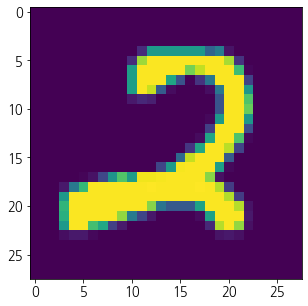

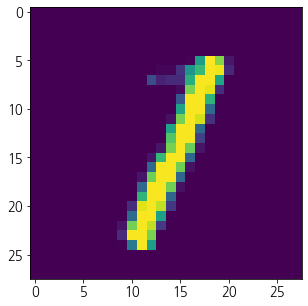

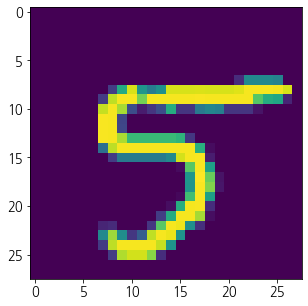

In [20]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize']=(5,5)
plt.rcParams.update({'font.size':13})

sample_size = 3
random_idx = np.random.randint(60000, size = sample_size)

for idx in random_idx:
    img = x_train[idx, :]
    label = y_train[idx]
    plt.figure()
    plt.imshow(img)

#### 3. 검증 데이터 만들기

In [31]:
from sklearn.model_selection import train_test_split

# 훈련, 테스트 데이터 7:3 비율로 분리
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.3, random_state = 777)
print(x_train.shape)
print(x_val.shape)

(42000, 28, 28)
(18000, 28, 28)


#### 4. 모델에 입력하기 전에 데이터 전처리(정규화)
    면접질문 : 정규화 또는 스케일을 해야하는 이유
        신경망은 입력 데이터의 스케일에 매우 민감하므로 적절한 전처리가 필수
        
    숫자의 하나의 픽셀이 0~255 사이의 범위에 있기 때문에 하나의 픽셀을 255로 나누면 0~1사이의 숫자로 스케일이 된다.

In [32]:
num_x_train = x_train.shape[0]
num_x_val = x_val.shape[0]
num_x_test = x_test.shape[0]

x_train = (x_train.reshape((num_x_train, 28*28)))/255
x_val = (x_val.reshape((num_x_val, 28*28)))/255
x_test = (x_test.reshape((num_x_test, 28*28)))/255

print(x_train.shape) # 모델 입력을 위해 데이터를 2차원으로 변경
print(x_val.shape)
print(x_test.shape)

(42000, 784)
(18000, 784)
(10000, 784)


#### 5. 모델 입력을 위한 레이블 전처리

In [33]:
from tensorflow.keras.utils import to_categorical

# mnist의 라벨 숫자를 One_Hot_encoding 함수
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
"""
loader2.py에 label_load에서 one hot encoding 했으므로 이파리 데이터 분류 신경망에서는 위의 코드를 사용하지 않음
"""
print(y_val)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### 6. 모델 구성하기

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()

model.add(Dense(64, input_shape=(784,), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))

#### 7. 모델과정 설정하기

In [35]:
from tensorflow.keras.losses import categorical_crossentropy
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

#### 8. 모델 학습하기

In [36]:
history = model.fit(x_train, y_train, epochs=30, batch_size=128, validation_data=(x_val, y_val))

Train on 42000 samples, validate on 18000 samples
Epoch 1/30
42000/42000 [==============================] - 3s 74us/sample - loss: 0.4763 - acc: 0.8654 - val_loss: 0.2444 - val_acc: 0.9291
Epoch 2/30
42000/42000 [==============================] - 1s 21us/sample - loss: 0.2074 - acc: 0.9398 - val_loss: 0.1923 - val_acc: 0.9446
Epoch 3/30
42000/42000 [==============================] - 2s 37us/sample - loss: 0.1560 - acc: 0.9540 - val_loss: 0.1617 - val_acc: 0.9529
Epoch 4/30
42000/42000 [==============================] - 1s 22us/sample - loss: 0.1273 - acc: 0.9628 - val_loss: 0.1402 - val_acc: 0.9579
Epoch 5/30
42000/42000 [==============================] - 1s 21us/sample - loss: 0.1075 - acc: 0.9688 - val_loss: 0.1287 - val_acc: 0.9614
Epoch 6/30
42000/42000 [==============================] - 1s 23us/sample - loss: 0.0911 - acc: 0.9739 - val_loss: 0.1249 - val_acc: 0.9624
Epoch 7/30
42000/42000 [==============================] - 1s 22us/sample - loss: 0.0796 - acc: 0.9768 - val_loss: 0.

#### 9. history를 통해 확인해 볼 수 있는 값 출력하기

In [37]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

#### 10. 시각화 코드

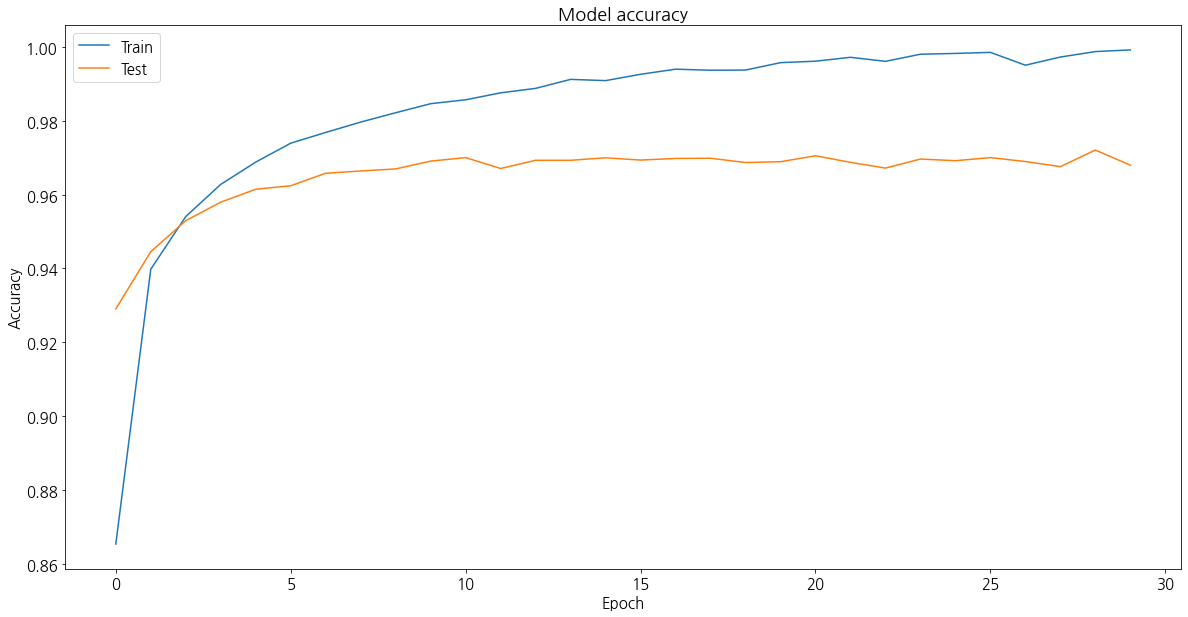

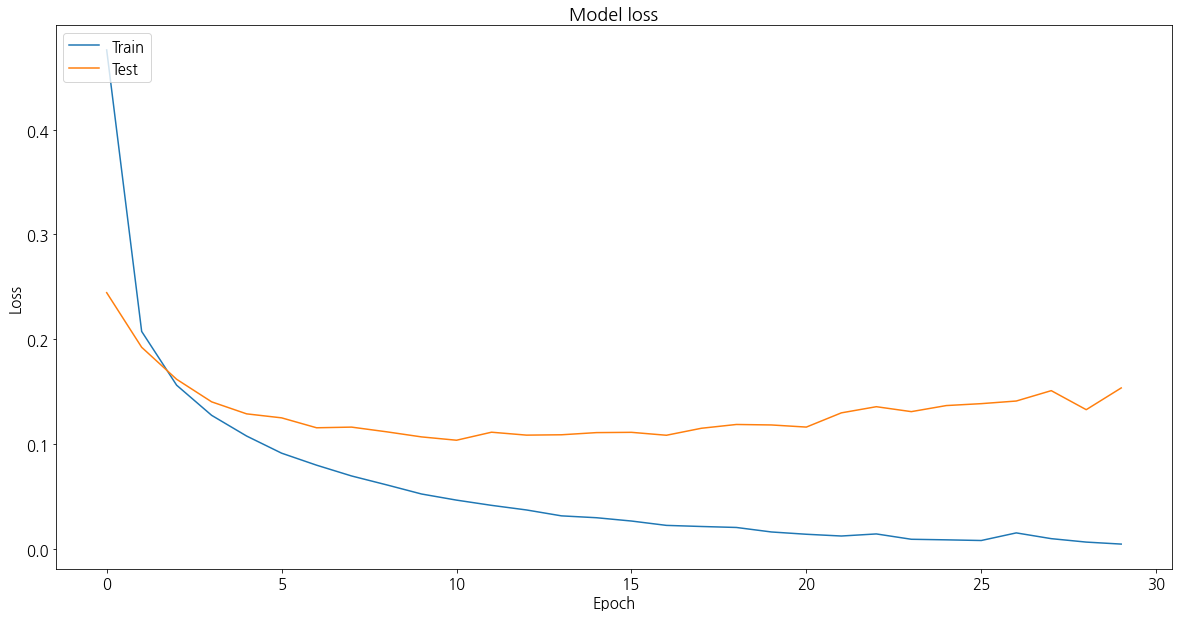

In [40]:
plt.rcParams['figure.figsize']=(20,10)
plt.rcParams.update({'font.size':15})

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()